# Multi Raw Aspect Modelling

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [1]:
PATH    = "./../data/multiple_raw.csv"

In [4]:
data = pd.read_csv(PATH, usecols=["ProductId", "Score", "Text"])

In [5]:
data.head()

,ProductId,Score,Text
0,2,5,great taffy great taffy great price wide assor...
1,2,5,great good expensive brand saltwater taffy gre...
2,2,5,wonderful tasty taffy taffy good soft chewy fl...
3,3,5,good hot sauce world know cactus tequila uniqu...
4,4,4,fresh greasy good flavor come securely pack fr...


In [6]:
# Return matrix of tfidf for each configuration of documents (rows) and words (columns)
vectorizer  = TfidfVectorizer()
word_sparse = vectorizer.fit_transform(data["Text"])

In [7]:
product_ids = data["ProductId"].values.reshape(-1,1)
product_ids_sparse = csr_matrix(product_ids)

In [9]:
x = hstack([product_ids, word_sparse])
y = data["Score"].values - 1

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42
)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(87412, 53794)
(87412,)
(21854, 53794)
(21854,)


## Neural Network Classifier

In [12]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 5

epoch_no    = 100
batch_size  = 512

In [13]:
# Define generator for training data
def train_generator():
    for i in range(x_train.shape[0]):
        yield x_train[i].toarray()[0].astype(np.float32), y_train[i]

# Define generator for testing data
def test_generator():
    for i in range(x_test.shape[0]):
        yield x_test[i].toarray()[0].astype(np.float32), y_test[i]

In [14]:
# TensorFlow Datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
# Add layers and activation function to neural network
nn_class    = tf.keras.Sequential()

nn_class.add(Input(shape=(input_dim,)))
nn_class.add(Dense(n_neurons_1, activation='relu'))
nn_class.add(Dense(n_neurons_2, activation='relu'))
nn_class.add(Dense(n_neurons_3, activation='relu'))
nn_class.add(Dense(output_dim, activation='sigmoid'))

# Configure loss function, gradient descent, and evaluation metrics
nn_class.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [16]:
nn_class.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 64s 367ms/step - accuracy: 0.4612 - loss: 11.7317
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - accuracy: 0.5428 - loss: 2.7927
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 293ms/step - accuracy: 0.6386 - loss: 1.4324
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 277ms/step - accuracy: 0.5946 - loss: 1.8258
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 47s 278ms/step - accuracy: 0.6345 - loss: 1.2678
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 292ms/step - accuracy: 0.6472 - loss: 1.1781
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.6350 - loss: 1.3343
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - accuracy: 0.6512 - loss: 1.1211
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.6517 - loss: 1.1068
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - accuracy: 0.5568 - loss: 2.8235
Epoch 11/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.6565 - loss: 1.0776
Epoch 12/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 57s 331ms/step - accuracy: 0.6533 - loss: 1.0900
Epoch 13/100
171/17

## Neural Network Regressor

In [21]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 1

epoch_no    = 100
batch_size  = 512

In [22]:
# Define generator for training data
def train_generator():
    for i in range(x_train.shape[0]):
        yield x_train[i].toarray()[0].astype(np.float32), y_train[i]

# Define generator for testing data
def test_generator():
    for i in range(x_test.shape[0]):
        yield x_test[i].toarray()[0].astype(np.float32), y_test[i]

In [23]:
# TensorFlow Datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [24]:
# Add layers and activation function to neural network
nn_reg    = tf.keras.Sequential()

nn_reg.add(Input(shape=(input_dim,)))
nn_reg.add(Dense(n_neurons_1, activation='relu'))
nn_reg.add(Dense(n_neurons_2, activation='relu'))
nn_reg.add(Dense(n_neurons_3, activation='relu'))
nn_reg.add(Dense(output_dim, activation='linear'))

# Configure loss function, gradient descent, and evaluation metrics
nn_reg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=["mae"]
)

In [26]:
reg_loss = nn_reg.fit(train_dataset, epochs=epoch_no)

Epoch 1/100


171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 320ms/step - loss: 1.4228 - mae: 0.9697
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


171/171 ━━━━━━━━━━━━━━━━━━━━ 53s 310ms/step - loss: 1.3411 - mae: 0.9299
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 53s 307ms/step - loss: 1.2792 - mae: 0.8993
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 321ms/step - loss: 1.3241 - mae: 0.8932
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - loss: 1.2185 - mae: 0.8424
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 56s 329ms/step - loss: 1.7877 - mae: 0.9593
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 56s 324ms/step - loss: 1.0150 - mae: 0.7743
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 316ms/step - loss: 0.9348 - mae: 0.7264
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 59s 347ms/step - loss: 0.9257 - mae: 0.7229
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - loss: 0.9487 - mae: 0.7347
Epoch 11/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 321ms/step - loss: 0.9589 - mae: 0.7365
Epoch 12/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 60s 354ms/step - loss: 0.9343 - mae: 0.7271
Epoch 13/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - loss: 0.9321 - 

## Evaluation

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC

652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
              precision    recall  f1-score   support

           0       0.55      0.50      0.52      1999
           1       0.20      0.00      0.00      1126
           2       0.67      0.00      0.00      1415
           3       0.43      0.00      0.00      2738
           4       0.71      1.00      0.83     13572

    accuracy                           0.70     20850
   macro avg       0.51      0.30      0.27     20850
weighted avg       0.63      0.70      0.59     20850



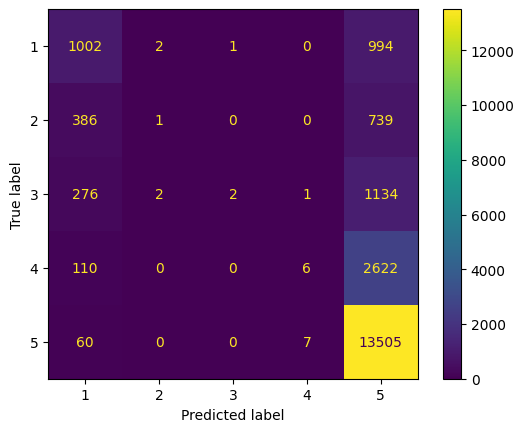

In [ ]:
# Neural Network Classification
nn_pred = nn_class.predict(x_test)
nn_pred = [np.argmax(arr) for arr in nn_pred]
print(classification_report(y_pred=nn_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.40      0.54      2046
           1       0.97      0.13      0.22      1136
           2       0.82      0.15      0.25      1516
           3       0.95      0.12      0.21      2815
           4       0.71      1.00      0.83     14341

    accuracy                           0.73     21854
   macro avg       0.86      0.36      0.41     21854
weighted avg       0.78      0.73      0.65     21854



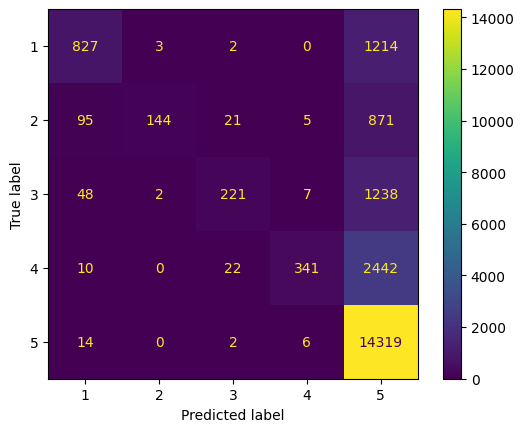

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

# Random Forest Classifier
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print(classification_report(y_pred=rf_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.show()

652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
              precision    recall  f1-score   support

           0       0.55      0.50      0.52      1999
           1       0.20      0.00      0.00      1126
           2       0.67      0.00      0.00      1415
           3       0.43      0.00      0.00      2738
           4       0.71      1.00      0.83     13572

    accuracy                           0.70     20850
   macro avg       0.51      0.30      0.27     20850
weighted avg       0.63      0.70      0.59     20850



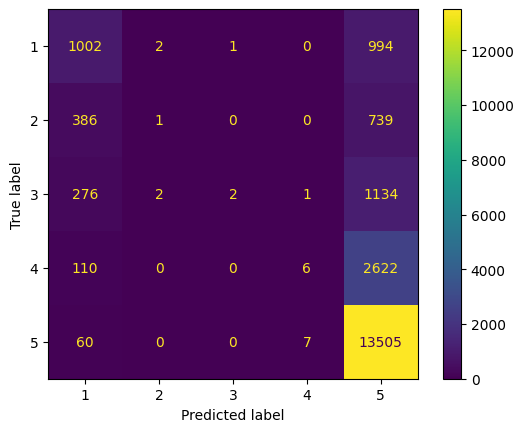

In [ ]:
# Neural Network Regression MSE
nn_pred = nn_reg.predict(x_test)
print(mean_squared_error(y_true=y_test, y_pred=nn_pred))

683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
0.7118011713027954


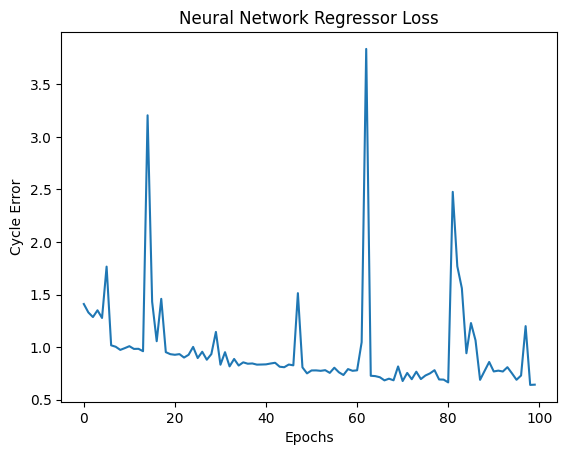

In [29]:
# Neural Network Regression MSE
nn_pred = nn_reg.predict(x_test)
print(mean_squared_error(y_true=y_test, y_pred=nn_pred))

plt.plot(reg_loss.history['loss'])
plt.title("Neural Network Regressor Loss")
plt.xlabel("Epochs")
plt.ylabel("Cycle Error")
plt.show()